# Reproducing results from the paper
In this notebook, the pretrained models are loaded and the results from the paper can be reproduced.

In [1]:
import scanpy as sc
import matplotlib.pyplot as plt
import torch
import os
import numpy as np
import pandas as pd
import yaml

In [2]:
import sys
sys.path.append('../')
import tcr_embedding as tcr

from tcr_embedding.evaluation.Imputation import run_imputation_evaluation
from tcr_embedding.evaluation.WrapperFunctions import get_model_prediction_function
from tcr_embedding.evaluation.Clustering import run_clustering_evaluation
from tcr_embedding.utils_training import init_model, show_umap, determine_marker_genes

In [3]:
%load_ext autoreload
%autoreload 2

## Set donor and model choice

In [4]:
DONOR_NR = '1'  # options: ['1', '2']
MODEL_TYPE = 'concat'  # options: ['RNA', 'TCR', 'concat', 'PoE']
base_path = '../saved_models/10x'

## Data

List of antigens per donor that has more than 100 cells in the train set

In [5]:
donor_1_high_count_antigens = ['A1101_IVTDFSVIK_EBNA-3B_EBV_binder',
                               'A0301_KLGGALQAK_IE-1_CMV_binder',
                               'A0201_GILGFVFTL_Flu-MP_Influenza_binder',
                               'A1101_AVFDRKSDAK_EBNA-3B_EBV_binder',
                               'A0201_ELAGIGILTV_MART-1_Cancer_binder']
donor_2_high_count_antigens = ['B0801_RAKFKQLL_BZLF1_EBV_binder',
                               'A0201_GILGFVFTL_Flu-MP_Influenza_binder',
                               'A0301_KLGGALQAK_IE-1_CMV_binder',
                               'A0201_GLCTLVAML_BMLF1_EBV_binder',
                               'A1101_AVFDRKSDAK_EBNA-3B_EBV_binder']

donor_specific_high_count_antigens = {'1': donor_1_high_count_antigens,
                                      '2': donor_2_high_count_antigens}

Load data and filter the data by donor and antigen specificity

In [6]:
adata_all = sc.read('../data/10x_CD8TC/v6_supervised.h5ad')
adata = adata_all[adata_all.obs['donor'] == 'donor_'+DONOR_NR]
adata = adata[adata.obs['binding_name'].isin(donor_specific_high_count_antigens[DONOR_NR])]
adata.obs['binding_name'] = adata.obs['binding_name'].astype(str)

Trying to set attribute `.obs` of view, copying.


Initialize a dict to store the results

In [7]:
results = {'donor': DONOR_NR, 'model_type': MODEL_TYPE}

## Initialize model and load pretrained weights

In [8]:
model_fp = f'10x_{MODEL_TYPE.lower()}_donor_{DONOR_NR}.pt'
file_path = os.path.join(base_path, model_fp)
model_file = torch.load(file_path)
params = model_file['params']
model = init_model(params, model_type=MODEL_TYPE, adata=adata, dataset_name='10x')
model.load(file_path)
test_embedding_func = get_model_prediction_function(model, batch_size=1024)  # helper function for evaluation functions

Load parameters used for UMAP and cluster scores in the paper

In [9]:
umap_params = yaml.safe_load(open(os.path.join(base_path, 'umap_params.yaml'), 'r'))

## Antigen specificity imputation using k-Nearest Neighbor

k-Nearest Neighbor classification is used on the latent representation to impute antigen specificity of the query set (test) with the atlas set (train). Results are stored in the results dict.

In [10]:
summary = run_imputation_evaluation(adata, test_embedding_func, query_source='test', use_non_binder=False, use_reduced_binders=True, num_neighbors=5)
results['kNN weighted f1-score'] = summary['knn']['weighted avg']['f1-score']

## Evaluate Cluster quality with Average Silhouette Width (AWS) and Normalized Mutual Information (NMI)

Evaluate the quality of clusters using the two metrics
- Average Silhouette Width: Measures how clear the clusters are separated
- Normalized Mutual Information: Harmonic mean between completeness (are all cells with the same antigen specificity in the same cluster or spread over multiple clusters?) and pureness (do the determined clusters contain only one antigen specificity or multiple?)
Clusters are determined using Leiden

In [11]:
cluster_results = run_clustering_evaluation(adata, test_embedding_func, 'all', name_label='binding_name', 
                                           cluster_params={'resolution': umap_params[DONOR_NR][MODEL_TYPE]['resolution'], 
                                                           'num_neighbors': 5}, visualize=False)
results['ASW'] = cluster_results['ASW']
results['NMI'] = cluster_results['NMI']

## UMAP visualization

Calculate UMAP and visualize. Each color indicates a different antigen specificity

**IMPORTANT**: The results are obtained using Windows 10, there may be slight differences in calculating the UMAPs on other operating systems even when fixing the random_state parameter (by default is 0). https://github.com/lmcinnes/umap/issues/153

... storing 'binding_name' as categorical


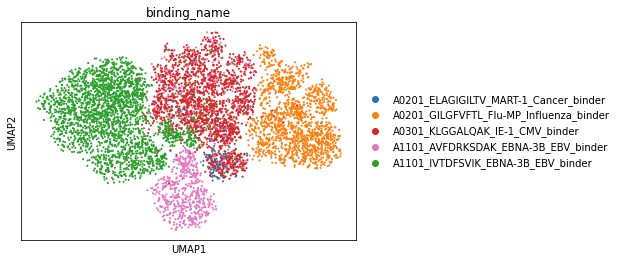

In [12]:
show_umap(adata, test_embedding_func, source_data='train', min_dist=umap_params[DONOR_NR][MODEL_TYPE]['min_dist'], 
          spread=umap_params[DONOR_NR][MODEL_TYPE]['spread'], palette=tcr.constants.ANTIGEN_COLORS)

## Show results

Show the results as a Pandas DataFrame

In [13]:
pd.set_option('precision', 2)
pd.DataFrame(results, index=['results'])

,donor,model_type,kNN weighted f1-score,ASW,NMI
results,1,concat,0.73,0.22,0.57


## Differential expression

Show the marker genes. First the marker genes needs to be determined, then the marker genes are visualized.

... storing 'binding_name' as categorical


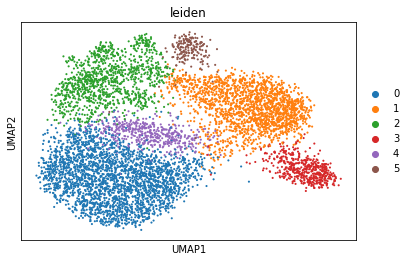

Trying to set attribute `.uns` of view, copying.


In [14]:
marker_genes = determine_marker_genes(adata, resolution=umap_params[DONOR_NR]['DGE']['resolution'], visualize=True)

Visualize log-transformed gene expression level of determined marker genes

... storing 'binding_name' as categorical


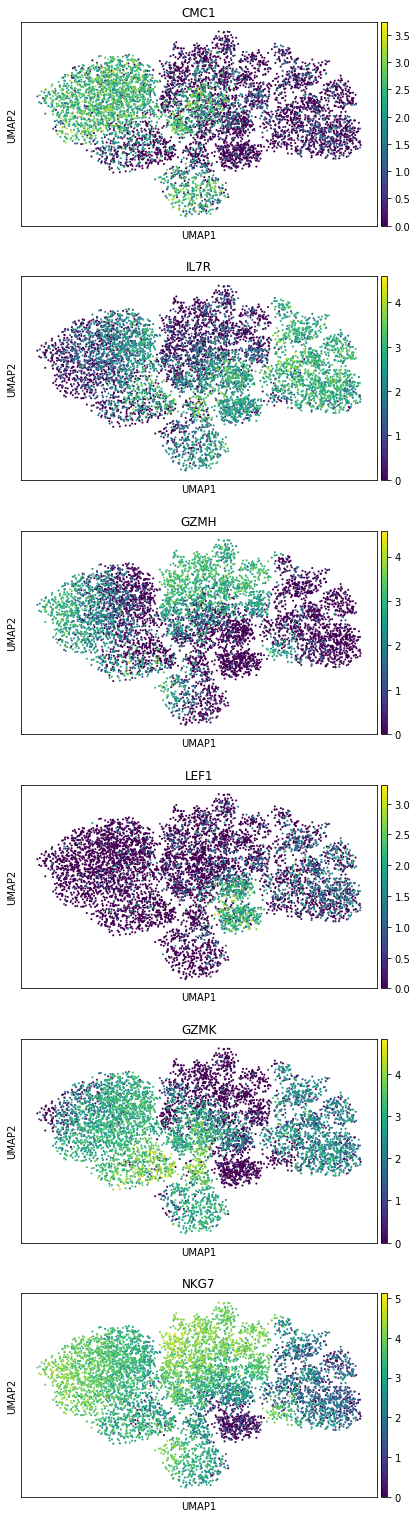

In [15]:
show_umap(adata, test_embedding_func, color=marker_genes, source_data='train', 
          min_dist=umap_params[DONOR_NR][MODEL_TYPE]['min_dist'], spread=umap_params[DONOR_NR][MODEL_TYPE]['spread'])